In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.preprocessing import image
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/My Drive/Food Classification'

image_path = '/content/drive/My Drive/Food Classification/'

datagen = ImageDataGenerator(rescale=1./255)
data_flow = datagen.flow_from_directory(
    directory=image_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)


Found 6269 images belonging to 20 classes.


In [ ]:
import os
import pandas as pd
from pathlib import Path

image_dir = Path('/content/drive/My Drive/Food Classification')

filepaths = list(image_dir.glob('**/*.jpg'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

images = pd.concat([filepaths, labels], axis=1)

category_samples = []
for category in images['Label'].unique():
    category_slice = images.query("Label == @category")
    category_samples.append(category_slice.sample(130, random_state=1))

image_df = pd.concat(category_samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)


In [ ]:
image_df['Label'].value_counts()

,count
Label,
momos,130
fried_rice,130
pakode,130
butter_naan,130
dhokla,130
pav_bhaji,130
jalebi,130
kaathi_rolls,130
samosa,130


In [ ]:
train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1)


In [ ]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [ ]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'

)

validation_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 1456 validated image filenames belonging to 20 classes.
Found 363 validated image filenames belonging to 20 classes.
Found 781 validated image filenames belonging to 20 classes.


In [ ]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)

x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(20, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)


print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,441,044 (9.31 MB)

 Trainable params: 183,060 (715.08 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

None


In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',

    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=validation_images,
    epochs=10,

    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,

            restore_best_weights=True,
            mode= 'min'
        )
    ]
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


46/46 ━━━━━━━━━━━━━━━━━━━━ 681s 13s/step - accuracy: 0.2811 - loss: 2.4601 - val_accuracy: 0.6749 - val_loss: 1.1102
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 121s 2s/step - accuracy: 0.7871 - loss: 0.7976 - val_accuracy: 0.7713 - val_loss: 0.8169
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 130s 3s/step - accuracy: 0.8746 - loss: 0.4932 - val_accuracy: 0.7851 - val_loss: 0.7188
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 0.9411 - loss: 0.2740 - val_accuracy: 0.7906 - val_loss: 0.7115
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 121s 3s/step - accuracy: 0.9764 - loss: 0.1451 - val_accuracy: 0.7989 - val_loss: 0.6956
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.9953 - loss: 0.0824 - val_accuracy: 0.7989 - val_loss: 0.7158
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - accuracy: 0.9984 - loss: 0.0445 - val_accuracy: 0.7851 - val_loss: 0.7163
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 160s 3s/step - accuracy: 1.0000 - loss: 0.0227 - val_accuracy: 0.8099 - val_loss: 0

In [ ]:
results = model.evaluate(test_images, verbose=0)

print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Accuracy: 78.49%


In [ ]:
predictions = np.argmax(model.predict(test_images), axis=1)

cm = confusion_matrix(test_images.labels, predictions)
clr = classification_report(test_images.labels, predictions, target_names=test_images.class_indices, zero_division=0)

25/25 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step


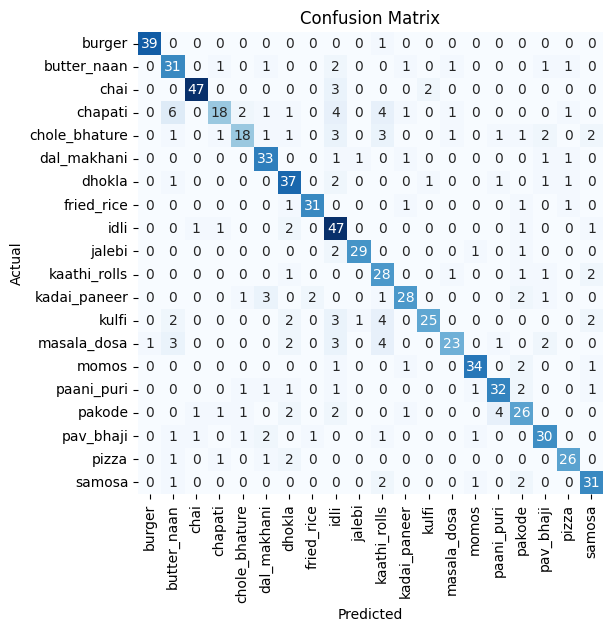

In [ ]:
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(20) + 0.5, labels=test_images.class_indices, rotation=90)
plt.yticks(ticks=np.arange(20) + 0.5, labels=test_images.class_indices, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
print("Classification Report:\n----------------------\n", clr)

Classification Report:
----------------------
                precision    recall  f1-score   support

       burger       0.97      0.97      0.97        40
  butter_naan       0.66      0.79      0.72        39
         chai       0.94      0.90      0.92        52
      chapati       0.78      0.46      0.58        39
chole_bhature       0.75      0.51      0.61        35
  dal_makhani       0.77      0.87      0.81        38
       dhokla       0.71      0.84      0.77        44
   fried_rice       0.91      0.89      0.90        35
         idli       0.64      0.89      0.74        53
       jalebi       0.94      0.88      0.91        33
 kaathi_rolls       0.58      0.82      0.68        34
 kadai_paneer       0.82      0.74      0.78        38
        kulfi       0.89      0.64      0.75        39
  masala_dosa       0.85      0.59      0.70        39
        momos       0.89      0.87      0.88        39
   paani_puri       0.82      0.80      0.81        40
       pakode    

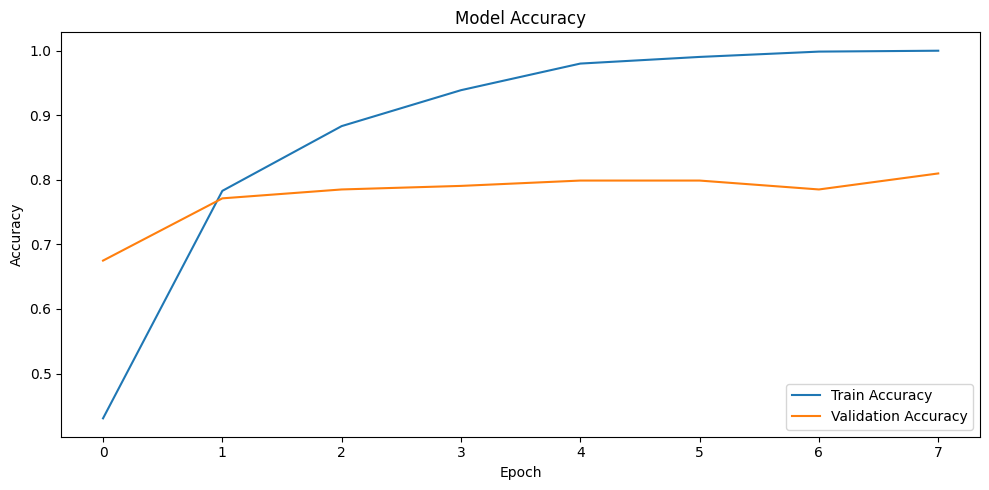

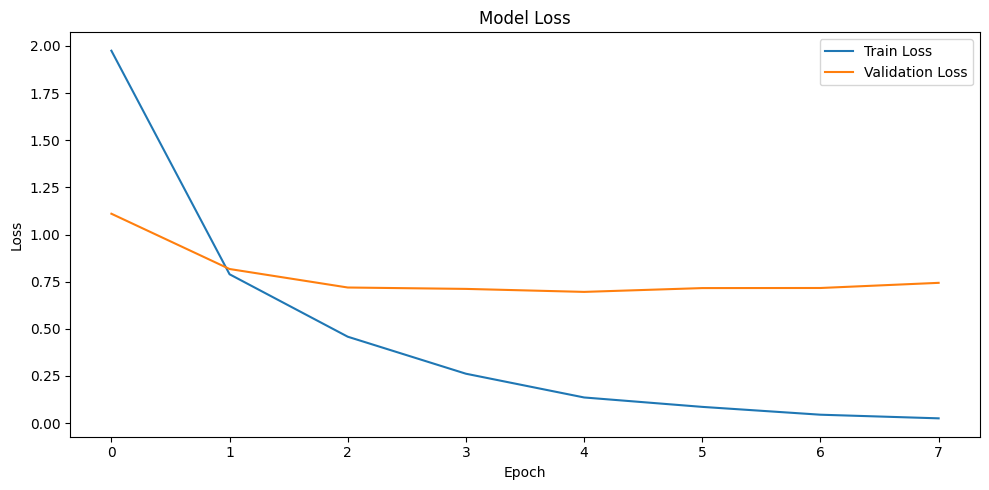

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
if 'fine_tune_history' in locals():  # Check if fine_tune_history exists
    plt.plot(np.arange(len(history.history['accuracy']), len(history.history['accuracy']) + len(fine_tune_history.history['accuracy'])),
             fine_tune_history.history['accuracy'], label='Fine-tune Train Accuracy')
    plt.plot(np.arange(len(history.history['val_accuracy']), len(history.history['val_accuracy']) + len(fine_tune_history.history['val_accuracy'])),
             fine_tune_history.history['val_accuracy'], label='Fine-tune Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
if 'fine_tune_history' in locals():  # Check if fine_tune_history exists
    plt.plot(np.arange(len(history.history['loss']), len(history.history['loss']) + len(fine_tune_history.history['loss'])),
             fine_tune_history.history['loss'], label='Fine-tune Train Loss')
    plt.plot(np.arange(len(history.history['val_loss']), len(history.history['val_loss']) + len(fine_tune_history.history['val_loss'])),
             fine_tune_history.history['val_loss'], label='Fine-tune Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()



# New Section